In [25]:
import torch
from torch import Tensor
from torch import nn 
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
from utility import *
np.random.seed(237699)

In [26]:
import dlc_bci

train_input_100 , train_target_100 = dlc_bci.load(root = './data_bci_100Hz', download = False)
test_input_100 , test_target_100 = dlc_bci.load(root = './data_bci_100Hz', download = False, train = False)

train_input_1000 , train_target_1000 = dlc_bci.load(root = './data_bci_1000Hz', download = False, one_khz = True)
test_input_1000 , test_target_1000 = dlc_bci.load(root = './data_bci_1000Hz', download = False, train = False, one_khz = True)

print("Train input 100 Hz: {:d}x{:d}x{:d}".format(*(s for s in train_input_100.size())))
print("Train target 100 Hz: {:d}".format(*(s for s in train_target_100.size())))
print("Test input 100 Hz: {:d}x{:d}x{:d}".format(*(s for s in test_input_100.size())))
print("Test target 100 Hz: {:d}".format(*(s for s in test_target_100.size())))
print("")
print("Train input 1000 Hz: {:d}x{:d}x{:d}".format(*(s for s in train_input_1000.size())))
print("Train target 1000 Hz: {:d}".format(*(s for s in train_target_1000.size())))
print("Test input 1000 Hz: {:d}x{:d}x{:d}".format(*(s for s in test_input_1000.size())))
print("Test target 1000 Hz: {:d}".format(*(s for s in test_target_1000.size())))

Ntrain = train_input_100.size(0)
Ntest = test_input_100.size(0)
Nchannels = train_input_100.size(1)
Nsamples_100 = train_input_100.size(-1)
Nsamples_1000 = train_input_1000.size(-1)

Train input 100 Hz: 316x28x50
Train target 100 Hz: 316
Test input 100 Hz: 100x28x50
Test target 100 Hz: 100

Train input 1000 Hz: 316x28x500
Train target 1000 Hz: 316
Test input 1000 Hz: 100x28x500
Test target 1000 Hz: 100


# Network definition

In [27]:
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        self.fc1 = nn.Linear(28*50,256)    
        self.fc2 = nn.Linear(256,512)
        self.fc3 = nn.Linear(512,256)
        self.fc4 = nn.Linear(256,64)
        self.fc5 = nn.Linear(64,1)
        
    def forward(self,x):
        
        x = x.view(-1,28*50)
        x = F.relu(self.fc1(x))
        x = F.dropout(x,0.8)
        x = F.relu(self.fc2(x))
        x = F.dropout(x,0.3)
        x = F.relu(self.fc3(x))
        x = F.dropout(x,0.3)
        x = F.relu(self.fc4(x))
        x = F.dropout(x,0.8)      
        x = F.softmax(self.fc5(x))
        if self.fc5.out_features==1:
            x=x.view(-1)
        
        return x

In [28]:
class MyNet2(nn.Module):
    def __init__(self):
        super(MyNet2, self).__init__()
        self.fc1 = nn.Linear(28*50,256)    
        self.fc2 = nn.Linear(256,1)

    def forward(self,x):

        x = x.view(-1,28*50)
        x = F.relu(self.fc1(x))     
        x = F.softmax(self.fc2(x))
        if self.fc2.out_features==1:
            x=x.view(-1)
        
        return x

In [29]:
class MyNet3(nn.Module):
    def __init__(self):
        super(MyNet3, self).__init__()
        self.fc1 = nn.Linear(28*50,128)    
        self.fc2 = nn.Linear(128,256)
        self.fc3 = nn.Linear(256,128)
        self.fc4 = nn.Linear(128,64)
        self.fc5 = nn.Linear(64,1)

    def forward(self,x):

        x = x.view(-1,28*50)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x)) 
        x = F.relu(self.fc3(x)) 
        x = F.relu(self.fc4(x)) 
        x = F.sigmoid(self.fc5(x))
        if self.fc5.out_features==1:
            x=x.view(-1)       
        return x

In [30]:
def compute_nb_errors(model, data_input, data_target, batch_size):
    nb_errors = 0
    Ndata = data_input.size(0)
    model.eval()
    
    for b_start in range(0, data_input.size(0), batch_size):
        bsize_eff = batch_size - max(0, b_start+batch_size-Ndata)  # boundary case
        batch_output = model.forward(data_input.narrow(0, b_start, bsize_eff))  # is Variable if data_input is Variable
        if len(list(batch_output.size()))>1 and batch_output.size(1) > 1:
            # as many ouputs as there are classes => select maximum output
            nb_err_batch = (batch_output.max(1)[1] != data_target.narrow(0, b_start, bsize_eff)).long().sum()
            # overflow problem if conversion to Long Int not performed, treated as short 1-byte int otherwise!!
        else:
            # output is a scalar in [0, 1]
            nb_err_batch = batch_output.round().sub(data_target.narrow(0, b_start, bsize_eff)).sign().abs().sum()
        
        nb_errors += nb_err_batch
    if isinstance(nb_errors, Variable):
        nb_errors = nb_errors.data[0]
    return nb_errors

# Preprocessing and Data Augmentation

In [31]:
import numpy as np

preprocessed_input_train, preprocessed_input_validation, preprocessed_input_train_target, preprocessed_input_validation_target = preprocessing_train_100(train_input_1000, train_target_1000, False, False)
preprocessed_input_test = preprocessing_test_100(test_input_100, False)

#Remove Noise
#preprocessed_input_train = denoisedSignals(preprocessed_input_train)
#preprocessed_input_validation = denoisedSignals(preprocessed_input_validation)
#preprocessed_input_test = denoisedSignals(preprocessed_input_test)
#add random noise
#preprocessed_input_train = whiteNoise(preprocessed_input_train)
#preprocessed_input_validation = whiteNoise(preprocessed_input_validation)
#preprocessed_input_test = whiteNoise(preprocessed_input_test)

print('train', preprocessed_input_train.shape)
print('test', preprocessed_input_test.shape)
print('validation', preprocessed_input_validation.shape)

labels_train = torch.from_numpy(preprocessed_input_train_target)
labels_test = test_target_100
labels_validation = torch.from_numpy(preprocessed_input_validation_target)

preprocessed_input_train = torch.from_numpy(preprocessed_input_train).float()
preprocessed_input_test = torch.from_numpy(preprocessed_input_test).float()
preprocessed_input_validation = torch.from_numpy(preprocessed_input_validation).float()

preprocessed_input_train_target = torch.from_numpy(preprocessed_input_train_target)
preprocessed_input_validation_target = torch.from_numpy(preprocessed_input_validation_target)

Ntrain = len(preprocessed_input_train[:,0,0])
Ntest = len(preprocessed_input_test[:,0,0])
Nvalidation = len(preprocessed_input_validation[:,0,0])

print('Ntrain', Ntrain)
print('Ntest', Ntest)
print('Nvalidation', Nvalidation)

train_input = Variable(preprocessed_input_train.view(Ntrain, 1, Nchannels, Nsamples_100))
validation_input = Variable(preprocessed_input_validation.view(Nvalidation, 1, Nchannels, Nsamples_100), volatile=True )
test_input = Variable(preprocessed_input_test.view(Ntest, 1, Nchannels, Nsamples_100), volatile=True )

train (3000, 28, 50)
test (100, 28, 50)
validation (160, 28, 50)
Ntrain 3000
Ntest 100
Nvalidation 160


# Network training and testing
Non-linearity: elu  


|criterion | optimizer | lr  | momentum | batch size | Nepochs | Train acc. | Test acc.|
|----------|-----------|-----|----------|------------|---------|------------|----------|

Non-linearity: ReLU

In [35]:
import torch.optim as optim
import math

# Train network 
#criterion = nn.BCELoss()
#criterion = nn.CrossEntropyLoss()
#criterion = nn.PoissonNLLLoss()
#criterion = nn.BCEWithLogitsLoss()
criterion = nn.SmoothL1Loss() #interesting ... but does not converge
#criterion = nn.MSELoss() #0.83 but unstable

if isinstance(criterion, nn.CrossEntropyLoss):
    train_target = Variable(preprocessed_input_train_target)  # keep long tensors
    validation_target = Variable(preprocessed_input_validation_target, volatile=True) # convert to float
    test_target = Variable(test_target_100, volatile=True )
    Noutputs = 2
    
elif isinstance(criterion, nn.NLLLoss):
    train_target = Variable(preprocessed_input_train_target)  # keep long tensors
    validation_target = Variable(preprocessed_input_validation_target, volatile=True) # convert to float
    test_target = Variable(test_target_100, volatile=True )
    Noutputs = 2
    
else:
    train_target = Variable(preprocessed_input_train_target.float()) # convert to float
    validation_target = Variable(preprocessed_input_validation_target.float(), volatile=True ) # convert to float
    test_target = Variable(test_target_100.float(), volatile=True )
    Noutputs = 1
        
model = MyNet()

#optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.40)
#optimizer = optim.Adam(model.parameters())
#optimizer = optim.Adagrad(model.parameters())
#optimizer = optim.Adamax(model.parameters())
#optimizer = optim.ASGD(model.parameters())
optimizer = optim.RMSprop(model.parameters())
#optimizer = optim.Rprop(model.parameters())

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, verbose=True)

batch_size = 15
Nbatches = int(math.ceil(Ntrain/batch_size))
Nepochs = 100
Nrep = 1

train_errors = torch.Tensor(Nepochs).zero_()
test_errors = torch.Tensor(Nepochs).zero_()
validation_errors = torch.Tensor(Nepochs).zero_()

ep_loss = torch.Tensor(Nepochs).zero_()

for i_rep in range(Nrep):
    for i_ep in range(Nepochs):
        for b_start in range(0, Ntrain, batch_size):
            bsize_eff = batch_size - max(0, b_start+batch_size-Ntrain)  # boundary case
            model.train()
            model.zero_grad()
            output = model(train_input.narrow(0, b_start, bsize_eff))
            batch_loss = criterion(output, train_target.narrow(0, b_start, bsize_eff))            
            ep_loss[i_ep] += batch_loss.data[0]
            batch_loss.backward()
            optimizer.step()
        
        scheduler.step(ep_loss[i_ep])
        
        nb_train_errs = compute_nb_errors(model, train_input, train_target, batch_size)
        nb_validation_errs = compute_nb_errors(model, validation_input, validation_target, batch_size)
        nb_test_errs = compute_nb_errors(model, test_input, test_target, batch_size)
        
        print("Epoch Number : ", i_ep)
        print("\t Training accuracy: ", (100*(Ntrain-nb_train_errs)/Ntrain))
        print("\t Validation accuracy ",(100*(Nvalidation-nb_validation_errs)/Nvalidation)) 
        print("\t Test accuracy ",(100*(Ntest-nb_test_errs)/Ntest))
        
        print("\t Epoch Loss ", ep_loss[i_ep])
        
        train_errors[i_ep] = nb_train_errs
        test_errors[i_ep] = nb_test_errs
        validation_errors[i_ep] = nb_validation_errs

C:\Users\nicol\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch Number :  0
	 Training accuracy:  50.333333333333336
	 Validation accuracy  37.5
	 Test accuracy  51.0
	 Epoch Loss  49.66667175292969
Epoch Number :  1
	 Training accuracy:  50.333333333333336
	 Validation accuracy  37.5
	 Test accuracy  51.0
	 Epoch Loss  49.66667175292969
Epoch Number :  2
	 Training accuracy:  50.333333333333336
	 Validation accuracy  37.5
	 Test accuracy  51.0
	 Epoch Loss  49.66667175292969
Epoch Number :  3
	 Training accuracy:  50.333333333333336
	 Validation accuracy  37.5
	 Test accuracy  51.0
	 Epoch Loss  49.66667175292969
Epoch Number :  4
	 Training accuracy:  50.333333333333336
	 Validation accuracy  37.5
	 Test accuracy  51.0
	 Epoch Loss  49.66667175292969
Epoch Number :  5
	 Training accuracy:  50.333333333333336
	 Validation accuracy  37.5
	 Test accuracy  51.0
	 Epoch Loss  49.66667175292969
Epoch Number :  6
	 Training accuracy:  50.333333333333336
	 Validation accuracy  37.5
	 Test accuracy  51.0
	 Epoch Loss  49.66667175292969
Epoch Number 

Epoch Number :  56
	 Training accuracy:  50.333333333333336
	 Validation accuracy  37.5
	 Test accuracy  51.0
	 Epoch Loss  49.66667175292969
Epoch Number :  57
	 Training accuracy:  50.333333333333336
	 Validation accuracy  37.5
	 Test accuracy  51.0
	 Epoch Loss  49.66667175292969
Epoch Number :  58
	 Training accuracy:  50.333333333333336
	 Validation accuracy  37.5
	 Test accuracy  51.0
	 Epoch Loss  49.66667175292969
Epoch Number :  59
	 Training accuracy:  50.333333333333336
	 Validation accuracy  37.5
	 Test accuracy  51.0
	 Epoch Loss  49.66667175292969
Epoch Number :  60
	 Training accuracy:  50.333333333333336
	 Validation accuracy  37.5
	 Test accuracy  51.0
	 Epoch Loss  49.66667175292969
Epoch Number :  61
	 Training accuracy:  50.333333333333336
	 Validation accuracy  37.5
	 Test accuracy  51.0
	 Epoch Loss  49.66667175292969
Epoch Number :  62
	 Training accuracy:  50.333333333333336
	 Validation accuracy  37.5
	 Test accuracy  51.0
	 Epoch Loss  49.66667175292969
Epoch 

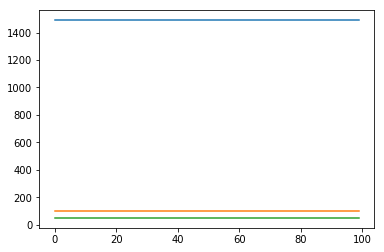

In [36]:
plt.plot(np.array(train_errors))
plt.plot(np.array(validation_errors))
plt.plot(np.array(test_errors))
plt.show()

In [ ]:
plt.plot(100*(Ntrain-np.array(train_errors))/Ntrain)
plt.plot(100*(Nvalidation-np.array(validation_errors))/Nvalidation)
plt.plot(100*(Ntest-np.array(test_errors))/Ntest)

plt.show()